# Model Retraining

- Setting up retraining pipelines, frequencies of retraining
- Training data preparation and storage
- Concept of Data Drift and how to track it
- Automated model retraining and model deployment

# Strategies to scale computationally
For some applications the amount of examples, features (or both) and/or the speed at which they need to be processed are challenging for traditional approaches. In these cases scikit-learn has a number of options you can consider to make your system scale.

### Scaling with instances using out-of-core learning
Out-of-core (or “external memory”) learning is a technique used to learn from data that cannot fit in a computer’s main memory (RAM).
Here is sketch of a system designed to achieve this goal:
- a way to stream instances
- a way to extract features from instances
- an incremental algorithm

We will look at 3 ways of doing this

1. Streaming instances
2. Extracting features
3. Incremental learning

### Incremental learning

Although all algorithms cannot learn incrementally (i.e. without seeing all the instances at once), all estimators implementing the partial_fit API are candidates. 

Actually, the ability to learn incrementally from a mini-batch of instances (sometimes called “online learning”) is key to out-of-core learning as it guarantees that at any given time there will be only a small amount of instances in the main memory. 

Choosing a good size for the mini-batch that balances relevancy and memory footprint could involve some tuning.

Here is a list of incremental estimators for different tasks:

### Classification
- ```sklearn.naive_bayes.MultinomialNB```
- ```sklearn.naive_bayes.BernoulliNB```
- ```sklearn.linear_model.Perceptron```
- ```sklearn.linear_model.SGDClassifier```
- ```sklearn.linear_model.PassiveAggressiveClassifier```

### Regression
- ```sklearn.linear_model.SGDRegressor```
- ```sklearn.linear_model.PassiveAggressiveRegressor```

### Clustering
- ```sklearn.cluster.MiniBatchKMeans```

### Decomposition / feature Extraction
- ```sklearn.decomposition.MiniBatchDictionaryLearning```
- ```sklearn.cluster.MiniBatchKMeans```

For classification, a somewhat important thing to note is that although a stateless feature extraction routine may be able to cope with new/unseen attributes, the incremental learner itself may be unable to cope with new/unseen targets classes. 

In this case you have to pass all the possible classes to the first ```partial_fit``` call using the ```classes= parameter```.

Another aspect to consider when choosing a proper algorithm is that all of them don’t put the same importance on each example over time. 

Namely, the Perceptron is still sensitive to badly labeled examples even after many examples whereas the ```SGD*``` and ```PassiveAggressive*``` families are more robust to this kind of artifacts. 

Conversely, the later also tend to give less importance to remarkably different, yet properly labeled examples when they come late in the stream as their learning rate decreases over time.

### Examples

Finally, we have a full-fledged example of Out-of-core classification of text documents. It is aimed at providing a starting point for people wanting to build out-of-core learning systems and demonstrates most of the notions discussed above.

Furthermore, it also shows the evolution of the performance of different algorithms with the number of processed examples.


![](https://scikit-learn.org/0.15/_images/plot_out_of_core_classification_001.png)

Now looking at the computation time of the different parts, we see that the vectorization is much more expensive than learning itself. From the different algorithms, MultinomialNB is the most expensive, but its overhead can be mitigated by increasing the size of the mini-batches (exercise: change minibatch_size to 100 and 10000 in the program and compare).

![](https://scikit-learn.org/0.15/_images/plot_out_of_core_classification_003.png)

### Classification
- ```sklearn.naive_bayes.MultinomialNB```
- ```sklearn.naive_bayes.BernoulliNB```
- ```sklearn.linear_model.Perceptron```
- ```sklearn.linear_model.SGDClassifier```
- ```sklearn.linear_model.PassiveAggressiveClassifier```

### MultinomialNB

In [1]:
### Let's load some data
import pandas as pd

In [2]:
df = pd.read_csv('datasets/Loan_default.csv')

In [3]:
df

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


### Let's do some data cleaning

In [4]:
df = df.drop('LoanID',axis=1)

In [5]:
df

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


In [6]:
df.isna().sum()

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

<Axes: >

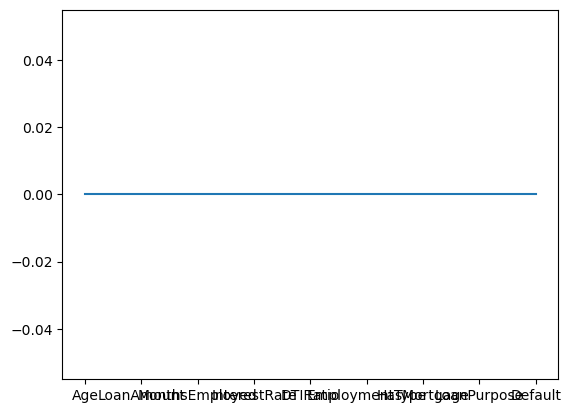

In [7]:
df.isna().sum().plot()

#### Wow, no missing values, my lucky day

![](https://i.pinimg.com/originals/c2/b0/9a/c2b09a209f8132aeb6de8d59bad31229.gif)

### Data Preprocessing
Let's just get started on converting the categorical columns to numbers

In [8]:
pd.get_dummies(df)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,56,85994,50587,520,80,4,15.23,36,0.44,0,...,True,False,True,False,False,False,False,True,False,True
1,69,50432,124440,458,15,1,4.81,60,0.68,0,...,False,True,False,False,False,False,False,True,False,True
2,46,84208,129188,451,26,3,21.17,24,0.31,1,...,True,False,True,True,False,False,False,False,True,False
3,32,31713,44799,743,0,3,7.07,24,0.23,0,...,False,True,False,False,True,False,False,False,True,False
4,60,20437,9139,633,8,4,6.51,48,0.73,0,...,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,0,...,False,True,False,False,False,False,False,True,True,False
255343,32,51953,189899,511,14,2,11.55,24,0.21,1,...,False,True,False,False,False,False,True,False,True,False
255344,56,84820,208294,597,70,3,5.29,60,0.50,0,...,True,False,True,True,False,False,False,False,False,True
255345,42,85109,60575,809,40,1,20.90,48,0.44,0,...,True,False,True,False,False,False,False,True,True,False


I know........

I know........

Not the best, but will do for now.

In [9]:
df_encoded = pd.get_dummies(df) 

In [10]:
df_encoded

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,56,85994,50587,520,80,4,15.23,36,0.44,0,...,True,False,True,False,False,False,False,True,False,True
1,69,50432,124440,458,15,1,4.81,60,0.68,0,...,False,True,False,False,False,False,False,True,False,True
2,46,84208,129188,451,26,3,21.17,24,0.31,1,...,True,False,True,True,False,False,False,False,True,False
3,32,31713,44799,743,0,3,7.07,24,0.23,0,...,False,True,False,False,True,False,False,False,True,False
4,60,20437,9139,633,8,4,6.51,48,0.73,0,...,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,0,...,False,True,False,False,False,False,False,True,True,False
255343,32,51953,189899,511,14,2,11.55,24,0.21,1,...,False,True,False,False,False,False,True,False,True,False
255344,56,84820,208294,597,70,3,5.29,60,0.50,0,...,True,False,True,True,False,False,False,False,False,True
255345,42,85109,60575,809,40,1,20.90,48,0.44,0,...,True,False,True,False,False,False,False,True,True,False


### Splitting X and Y

In [11]:
X = df_encoded.drop('Default',axis=1)
y = df_encoded['Default']

In [12]:
X

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_Bachelor's,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,56,85994,50587,520,80,4,15.23,36,0.44,True,...,True,False,True,False,False,False,False,True,False,True
1,69,50432,124440,458,15,1,4.81,60,0.68,False,...,False,True,False,False,False,False,False,True,False,True
2,46,84208,129188,451,26,3,21.17,24,0.31,False,...,True,False,True,True,False,False,False,False,True,False
3,32,31713,44799,743,0,3,7.07,24,0.23,False,...,False,True,False,False,True,False,False,False,True,False
4,60,20437,9139,633,8,4,6.51,48,0.73,True,...,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,True,...,False,True,False,False,False,False,False,True,True,False
255343,32,51953,189899,511,14,2,11.55,24,0.21,False,...,False,True,False,False,False,False,True,False,True,False
255344,56,84820,208294,597,70,3,5.29,60,0.50,False,...,True,False,True,True,False,False,False,False,False,True
255345,42,85109,60575,809,40,1,20.90,48,0.44,False,...,True,False,True,False,False,False,False,True,True,False


In [13]:
y

0         0
1         0
2         1
3         0
4         0
         ..
255342    0
255343    1
255344    0
255345    0
255346    0
Name: Default, Length: 255347, dtype: int64

### Time for train test split 

### Now that my dataset is ready 
I am going to split my data not into train and test, but rather train/validate/test to prove my point

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, train_size=0.67, random_state=42)

### So now
```33%``` of my data is in ```X_test``` and ```y_test```, I will reserve this for later.

The remaining ```66%``` of my data is in ```X_train``` and ```y_train```

### Splitting it again



In [16]:
# Split the data into training and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.5, train_size=0.5, random_state=42)

```X_train_2``` and ```y_train_2``` is what i will use for training. 

```X_test``` and ```y_test``` is what i will use for testing.

### Let's Begin !!!!

```MultinomialNB```

In [17]:
from sklearn.naive_bayes import MultinomialNB

In [19]:
# Initialise the model
clf = MultinomialNB()

# Train the model 
clf.fit(X_train_2, y_train_2)

MultinomialNB()

### Training Done
### Predict on the test set

In [20]:
# Getting my predictions
clf.predict(X_test_2)

array([1, 0, 0, ..., 1, 0, 1])

In [22]:
# Saving my predictions
pred = clf.predict(X_test_2)

### Get some metrics

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, pred)

0.5780035304707684

### Saving the model

In [24]:
from joblib import load,dump

In [26]:
dump(clf,'models/MultinomialNB.pkl')

['models/MultinomialNB.pkl']

### Now, this is where we would typically stop. 

But not this time !!!!!!!!!!

In [91]:
loaded_model = load('models/MultinomialNB.pkl')

In [92]:
loaded_model

MultinomialNB()

In [31]:
# ############### Only for demonstration purposes ###############


# # What happens if you do fit
# loaded_model.fit(new_data)

# # What happens if you do this 
# loaded_model.partial_fit(new_data)

# # Additionally what happens when you do this 
# loaded_model.fit(new_data, warm_start=True)

# ############################################################

### Time for training on top

In [49]:
loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [56]:
# For testing
for i in range(100):
    loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [57]:
loaded_model_trained

MultinomialNB()

In [58]:
# Getting my predictions
loaded_model_trained.predict(X_test_2)

array([1, 0, 0, ..., 1, 0, 1])

In [59]:
# Storing my predictions
loaded_model_pred = loaded_model_trained.predict(X_test_2)

In [60]:
# Here are my predictions
loaded_model_pred

array([1, 0, 0, ..., 1, 0, 1])

In [61]:
# Getting my accuracy 

from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, loaded_model_pred)

0.5785880454986497

In [90]:
# For initial
0.5780035304707684

# For 1 run 
0.57833

# For 5 runs
0.5785529745969769

# For 25 runs
0.5785763551980921

# For 100 more
0.5785880454986497

0.5785880454986497

In [93]:
# Training on top, multiple epoch
acc_list = []

for i in range(1,500,50):
    loaded_model_trained = loaded_model.partial_fit(X_train,y_train)
    loaded_model_pred = loaded_model_trained.predict(X_test_2)
    
    acc_list.append(accuracy_score(y_test_2, loaded_model_pred))

In [94]:
x_range_temp = []
for i in range(1,500,50):
    x_range_temp.append(i)

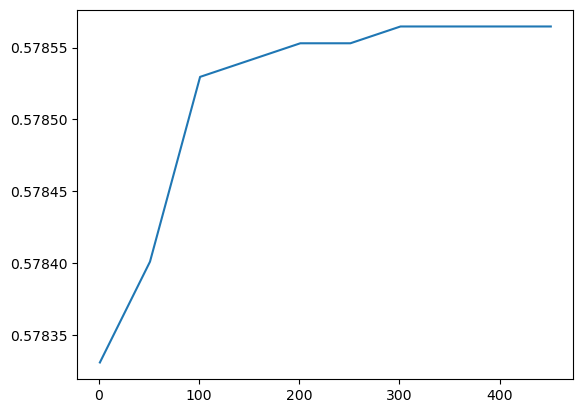

In [95]:
plt.plot(x_range_temp,acc_list)

-----

```BernoulliNB```

In [68]:
from sklearn.naive_bayes import BernoulliNB

In [69]:
# Initialising my model
clf = BernoulliNB()

# Training my model
clf.fit(X_train_2, y_train_2)

BernoulliNB()

### Training Done
### Predict on the test set

In [70]:
# Getting my predictions
clf.predict(X_test_2)

array([0, 0, 0, ..., 0, 0, 0])

In [71]:
# Saving my predictions
pred = clf.predict(X_test_2)

In [72]:
pred

array([0, 0, 0, ..., 0, 0, 0])

### Get some metrics

In [73]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, pred)

0.8844296886872961

### Saving the model

In [74]:
from joblib import load,dump

In [75]:
dump(clf,'models/BernoulliNB.pkl')

['models/BernoulliNB.pkl']

### Now, this is where we would typically stop. 

But not this time !!!!!!!!!!

In [78]:
loaded_model = load('models/BernoulliNB.pkl')

In [79]:
loaded_model

BernoulliNB()

### Time for training on top

In [80]:
# Training on top, 1 epoch
loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [81]:
loaded_model_trained

BernoulliNB()

In [82]:
# Getting my predictions
loaded_model_trained.predict(X_test_2)

array([0, 0, 0, ..., 0, 0, 0])

In [84]:
# Storing my predictions
loaded_model_pred = loaded_model_trained.predict(X_test_2)

In [85]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, loaded_model_pred)

0.8844296886872961

In [ ]:
# Orignal
0.8844296886872961

# After 1 epoch 
0.8844296886872961

In [86]:
# Training on top, multiple epoch
acc_list = []

for i in range(1,500,50):
    loaded_model_trained = loaded_model.partial_fit(X_train,y_train)
    loaded_model_pred = loaded_model_trained.predict(X_test_2)
    
    acc_list.append(accuracy_score(y_test_2, loaded_model_pred))
    
x_range_temp = []
for i in range(1,500,50):
    x_range_temp.append(i)

plt.plot(x_range_temp,acc_list)

-----

```Perceptron```

In [96]:
from sklearn.linear_model import Perceptron

In [97]:
clf = Perceptron()
clf.fit(X_train_2, y_train_2)

Perceptron()

### Training Done
### Predict on the test set

In [98]:
clf.predict(X_test_2)

array([0, 1, 0, ..., 0, 1, 0])

In [99]:
pred = clf.predict(X_test_2)

### Get some metrics

In [100]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, pred)

0.7558130019522802

### Saving the model

In [101]:
from joblib import load,dump

In [102]:
dump(clf,'models/Perceptron.pkl')

['models/Perceptron.pkl']

### Now, this is where we would typically stop. 

But not this time !!!!!!!!!!

In [103]:
loaded_model = load('models/Perceptron.pkl')

In [104]:
loaded_model

Perceptron()

### Time for training on top

In [105]:
loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [106]:
loaded_model_trained

Perceptron()

In [107]:
loaded_model_trained.predict(X_test_2)

array([0, 0, 0, ..., 0, 0, 0])

In [108]:
loaded_model_pred = loaded_model_trained.predict(X_test_2)

In [110]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, loaded_model_pred)

0.8844296886872961

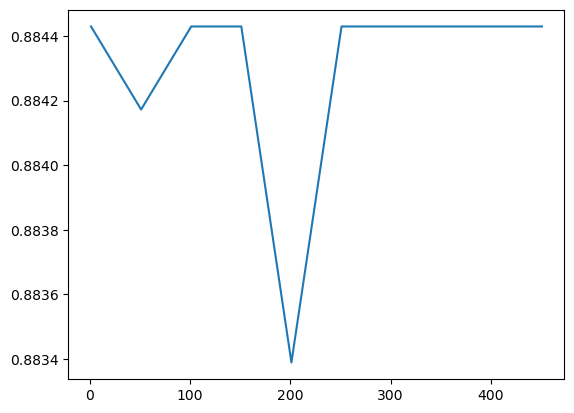

In [111]:
# Training on top, multiple epoch
acc_list = []

for i in range(1,500,50):
    loaded_model_trained = loaded_model.partial_fit(X_train,y_train)
    loaded_model_pred = loaded_model_trained.predict(X_test_2)
    
    acc_list.append(accuracy_score(y_test_2, loaded_model_pred))
    
x_range_temp = []
for i in range(1,500,50):
    x_range_temp.append(i)

plt.plot(x_range_temp,acc_list)

-----

```SGDClassifier```

In [112]:
from sklearn.linear_model import SGDClassifier

In [113]:
clf = SGDClassifier()
clf.fit(X_train_2, y_train_2)

SGDClassifier()

### Training Done
### Predict on the test set

In [114]:
clf.predict(X_test_2)

array([0, 0, 0, ..., 0, 0, 0])

In [115]:
pred = clf.predict(X_test_2)

### Get some metrics

In [116]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, pred)

0.8844296886872961

### Saving the model

In [117]:
from joblib import load,dump

In [118]:
dump(clf,'models/SGDClassifier.pkl')

['models/SGDClassifier.pkl']

### Now, this is where we would typically stop. 

But not this time !!!!!!!!!!

In [119]:
loaded_model = load('models/SGDClassifier.pkl')

In [120]:
loaded_model

SGDClassifier()

### Time for training on top

In [121]:
loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [122]:
loaded_model_trained

SGDClassifier()

In [123]:
loaded_model_trained.predict(X_test_2)

array([0, 0, 0, ..., 0, 0, 0])

In [124]:
loaded_model_pred = loaded_model_trained.predict(X_test_2)

In [126]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, loaded_model_pred)

0.8844296886872961

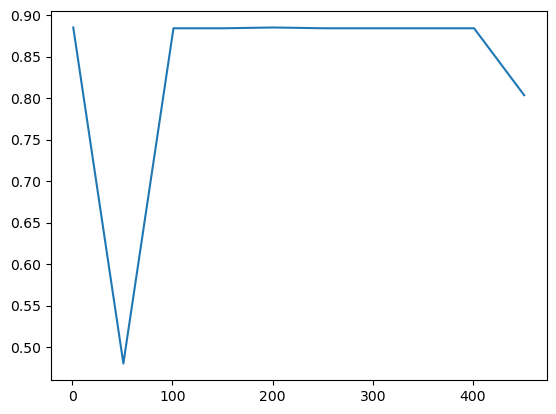

In [127]:
# Training on top, multiple epoch
acc_list = []

for i in range(1,500,50):
    loaded_model_trained = loaded_model.partial_fit(X_train,y_train)
    loaded_model_pred = loaded_model_trained.predict(X_test_2)
    
    acc_list.append(accuracy_score(y_test_2, loaded_model_pred))
    
x_range_temp = []
for i in range(1,500,50):
    x_range_temp.append(i)

plt.plot(x_range_temp,acc_list)

-----

```PassiveAggressiveClassifier```

In [128]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [129]:
clf = PassiveAggressiveClassifier()
clf.fit(X_train_2, y_train_2)

PassiveAggressiveClassifier()

### Training Done
### Predict on the test set

In [130]:
clf.predict(X_test_2)

array([0, 0, 0, ..., 0, 0, 0])

In [131]:
pred = clf.predict(X_test_2)

### Get some metrics

In [132]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, pred)

0.8844296886872961

### Saving the model

In [133]:
from joblib import load,dump

In [134]:
dump(clf,'models/PassiveAggressiveClassifier.pkl')

['models/PassiveAggressiveClassifier.pkl']

### Now, this is where we would typically stop. 

But not this time !!!!!!!!!!

In [135]:
loaded_model = load('models/PassiveAggressiveClassifier.pkl')

In [136]:
loaded_model

PassiveAggressiveClassifier()

### Time for training on top

In [137]:
loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [138]:
loaded_model_trained

PassiveAggressiveClassifier()

In [139]:
loaded_model_trained.predict(X_test_2)

array([0, 0, 0, ..., 0, 0, 0])

In [140]:
loaded_model_pred = loaded_model_trained.predict(X_test_2)

In [141]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, loaded_model_pred)

0.8844296886872961

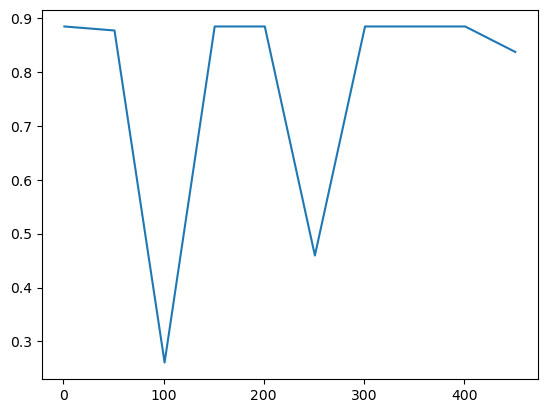

In [142]:
# Training on top, multiple epoch
acc_list = []

for i in range(1,500,50):
    loaded_model_trained = loaded_model.partial_fit(X_train,y_train)
    loaded_model_pred = loaded_model_trained.predict(X_test_2)
    
    acc_list.append(accuracy_score(y_test_2, loaded_model_pred))
    
x_range_temp = []
for i in range(1,500,50):
    x_range_temp.append(i)

plt.plot(x_range_temp,acc_list)

### Regression

- ```sklearn.linear_model.SGDRegressor```
- ```sklearn.linear_model.PassiveAggressiveRegressor```

### Loading data

In [143]:
df = pd.read_csv('datasets/supermarket_sales.csv')

In [144]:
df

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


### EDA

In [145]:
df = df.drop(['Invoice ID','Date','Time'] ,axis=1)

In [146]:
df

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Payment,cogs,gross margin percentage,gross income,Rating
0,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,Ewallet,522.83,4.761905,26.1415,9.1
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,76.40,4.761905,3.8200,9.6
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,324.31,4.761905,16.2155,7.4
3,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,Ewallet,465.76,4.761905,23.2880,8.4
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,Ewallet,40.35,4.761905,2.0175,6.2
996,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,Ewallet,973.80,4.761905,48.6900,4.4
997,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,Cash,31.84,4.761905,1.5920,7.7
998,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,Cash,65.82,4.761905,3.2910,4.1


### Checking if all data types are in correct order

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Branch                   1000 non-null   object 
 1   City                     1000 non-null   object 
 2   Customer type            1000 non-null   object 
 3   Gender                   1000 non-null   object 
 4   Product line             1000 non-null   object 
 5   Unit price               1000 non-null   float64
 6   Quantity                 1000 non-null   int64  
 7   Tax 5%                   1000 non-null   float64
 8   Total                    1000 non-null   float64
 9   Payment                  1000 non-null   object 
 10  cogs                     1000 non-null   float64
 11  gross margin percentage  1000 non-null   float64
 12  gross income             1000 non-null   float64
 13  Rating                   1000 non-null   float64
dtypes: float64(7), int64(1), 

All good !!

### Missing values

In [150]:
df.isna().sum()

Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

In [151]:
df

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Payment,cogs,gross margin percentage,gross income,Rating
0,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,Ewallet,522.83,4.761905,26.1415,9.1
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,76.40,4.761905,3.8200,9.6
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,324.31,4.761905,16.2155,7.4
3,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,Ewallet,465.76,4.761905,23.2880,8.4
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,Ewallet,40.35,4.761905,2.0175,6.2
996,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,Ewallet,973.80,4.761905,48.6900,4.4
997,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,Cash,31.84,4.761905,1.5920,7.7
998,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,Cash,65.82,4.761905,3.2910,4.1


### Encoding

In [152]:
pd.get_dummies(df)

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating,Branch_A,Branch_B,...,Gender_Male,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,74.69,7,26.1415,548.9715,522.83,4.761905,26.1415,9.1,True,False,...,False,False,False,False,True,False,False,False,False,True
1,15.28,5,3.8200,80.2200,76.40,4.761905,3.8200,9.6,False,False,...,False,True,False,False,False,False,False,True,False,False
2,46.33,7,16.2155,340.5255,324.31,4.761905,16.2155,7.4,True,False,...,True,False,False,False,False,True,False,False,True,False
3,58.22,8,23.2880,489.0480,465.76,4.761905,23.2880,8.4,True,False,...,True,False,False,False,True,False,False,False,False,True
4,86.31,7,30.2085,634.3785,604.17,4.761905,30.2085,5.3,True,False,...,True,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,40.35,1,2.0175,42.3675,40.35,4.761905,2.0175,6.2,False,False,...,True,False,False,False,True,False,False,False,False,True
996,97.38,10,48.6900,1022.4900,973.80,4.761905,48.6900,4.4,False,True,...,False,False,False,False,False,True,False,False,False,True
997,31.84,1,1.5920,33.4320,31.84,4.761905,1.5920,7.7,True,False,...,True,False,False,True,False,False,False,True,False,False
998,65.82,1,3.2910,69.1110,65.82,4.761905,3.2910,4.1,True,False,...,True,False,False,False,False,True,False,True,False,False


In [153]:
df_encoded = pd.get_dummies(df)

### Splitting X and Y

In [154]:
X = df_encoded.drop('Rating',axis=1)
y = df_encoded['Rating']

In [155]:
X

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Branch_A,Branch_B,Branch_C,...,Gender_Male,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,74.69,7,26.1415,548.9715,522.83,4.761905,26.1415,True,False,False,...,False,False,False,False,True,False,False,False,False,True
1,15.28,5,3.8200,80.2200,76.40,4.761905,3.8200,False,False,True,...,False,True,False,False,False,False,False,True,False,False
2,46.33,7,16.2155,340.5255,324.31,4.761905,16.2155,True,False,False,...,True,False,False,False,False,True,False,False,True,False
3,58.22,8,23.2880,489.0480,465.76,4.761905,23.2880,True,False,False,...,True,False,False,False,True,False,False,False,False,True
4,86.31,7,30.2085,634.3785,604.17,4.761905,30.2085,True,False,False,...,True,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,40.35,1,2.0175,42.3675,40.35,4.761905,2.0175,False,False,True,...,True,False,False,False,True,False,False,False,False,True
996,97.38,10,48.6900,1022.4900,973.80,4.761905,48.6900,False,True,False,...,False,False,False,False,False,True,False,False,False,True
997,31.84,1,1.5920,33.4320,31.84,4.761905,1.5920,True,False,False,...,True,False,False,True,False,False,False,True,False,False
998,65.82,1,3.2910,69.1110,65.82,4.761905,3.2910,True,False,False,...,True,False,False,False,False,True,False,True,False,False


In [156]:
y

0      9.1
1      9.6
2      7.4
3      8.4
4      5.3
      ... 
995    6.2
996    4.4
997    7.7
998    4.1
999    6.6
Name: Rating, Length: 1000, dtype: float64

### Time for train test split 

### Now that my dataset is ready 
I am going to split my data not into train and test, but rather train/validate/test to prove my point

In [157]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, train_size=0.67, random_state=42)

### So now
```33%``` of my data is in ```X_test``` and ```y_test```, I will reserve this for later.

The remaining ```66%``` of my data is in ```X_train``` and ```y_train```

### Splitting it again



In [158]:
# Split the data into training and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.5, train_size=0.5, random_state=42)

```X_train_2``` and ```y_train_2``` is what i will use for training. 

```X_test``` and ```y_test``` is what i will use for testing.

### Let's Begin !!!!

```SGDRegressor```

In [159]:
from sklearn.linear_model import SGDRegressor

In [160]:
# Initialising 
reg = SGDRegressor()

# Training
reg.fit(X_train_2, y_train_2)

SGDRegressor()

### Training Done
### Predict on the test set

In [161]:
pred = reg.predict(X_test_2)

### Get some metrics

In [162]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test_2, pred)

2.623257939752164e+26

In [163]:
import math 

math.sqrt(mean_squared_error(y_test_2, pred))

16196474739128.154

### Saving the model

In [164]:
from joblib import load,dump

In [165]:
dump(reg,'models/SGDRegressor.pkl')

['models/SGDRegressor.pkl']

### Now, this is where we would typically stop. 

But not this time !!!!!!!!!!

In [166]:
loaded_model = load('models/SGDRegressor.pkl')

In [167]:
loaded_model

SGDRegressor()

### Time for training on top

In [168]:
loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [169]:
loaded_model_trained

SGDRegressor()

In [171]:
# loaded_model_trained.predict(X_test_2)

In [173]:
# Storing my predictions
loaded_model_pred = loaded_model_trained.predict(X_test_2)

### Get some metrics

In [174]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test_2, loaded_model_pred)

1.403806197381208e+27

In [175]:
import math 

math.sqrt(mean_squared_error(y_test_2, loaded_model_pred))

37467401796511.164

In [ ]:
16196474739128.154
37467401796511.164

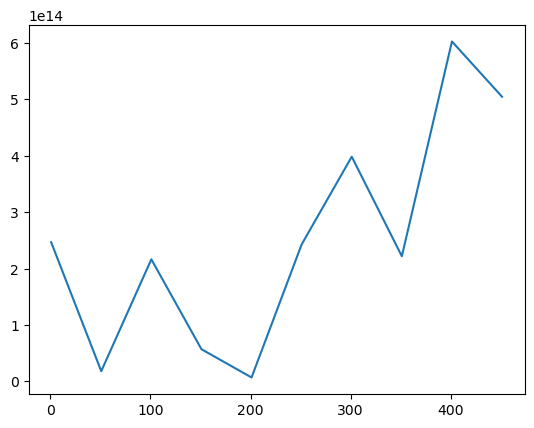

In [176]:
# Training on top, multiple epoch
acc_list = []

for i in range(1,500,50):
    loaded_model_trained = loaded_model.partial_fit(X_train,y_train)
    loaded_model_pred = loaded_model_trained.predict(X_test_2)
    
    acc_list.append(math.sqrt(mean_squared_error(y_test_2, loaded_model_pred)))
    
x_range_temp = []
for i in range(1,500,50):
    x_range_temp.append(i)

plt.plot(x_range_temp,acc_list)

----

```PassiveAggressiveRegressor```

In [177]:
from sklearn.linear_model import PassiveAggressiveRegressor

In [178]:
reg = PassiveAggressiveRegressor()
reg.fit(X_train_2, y_train_2)

PassiveAggressiveRegressor()

### Training Done
### Predict on the test set

In [179]:
# Storing my predictions
pred = reg.predict(X_test_2)

### Get some metrics

In [180]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test_2, pred)

10.244394284285308

In [181]:
import math 

math.sqrt(mean_squared_error(y_test_2, pred))

3.200686533274589

### Saving the model

In [182]:
from joblib import load,dump

In [183]:
dump(reg,'models/PassiveAggressiveRegressor.pkl')

['models/PassiveAggressiveRegressor.pkl']

### Now, this is where we would typically stop. 

But not this time !!!!!!!!!!

In [184]:
loaded_model = load('models/PassiveAggressiveRegressor.pkl')

In [185]:
loaded_model

PassiveAggressiveRegressor()

### Time for training on top

In [186]:
loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [187]:
loaded_model_trained

PassiveAggressiveRegressor()

In [189]:
# loaded_model_trained.predict(X_test_2)

In [190]:
loaded_model_pred = loaded_model_trained.predict(X_test_2)

### Get some metrics

In [191]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test_2, loaded_model_pred)

33.49681971012669

In [192]:
import math 

math.sqrt(mean_squared_error(y_test_2, loaded_model_pred))

5.787643709673798

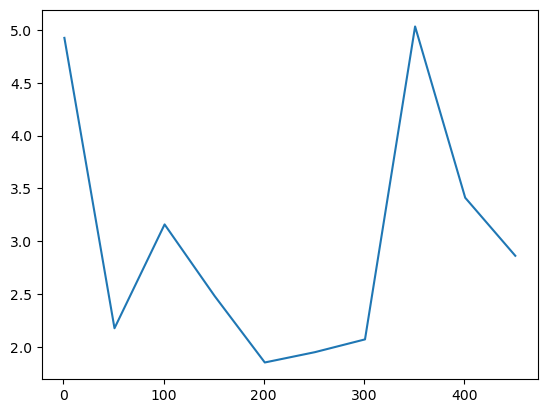

In [193]:
# Training on top, multiple epoch
acc_list = []

for i in range(1,500,50):
    loaded_model_trained = loaded_model.partial_fit(X_train,y_train)
    loaded_model_pred = loaded_model_trained.predict(X_test_2)
    
    acc_list.append(math.sqrt(mean_squared_error(y_test_2, loaded_model_pred)))
    
x_range_temp = []
for i in range(1,500,50):
    x_range_temp.append(i)

plt.plot(x_range_temp,acc_list)

----

### Clustering

In [232]:
df = pd.read_csv('datasets/segmentation data.csv')

In [233]:
df

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,100001996,1,0,47,1,123525,0,0
1996,100001997,1,1,27,1,117744,1,0
1997,100001998,0,0,31,0,86400,0,0
1998,100001999,1,1,24,1,97968,0,0


### EDA

In [234]:
df.isna().sum()

ID                 0
Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

No missing values

In [235]:
df = df.drop(['ID', 'Settlement size'], axis = 1)

In [236]:
df

,Sex,Marital status,Age,Education,Income,Occupation
0,0,0,67,2,124670,1
1,1,1,22,1,150773,1
2,0,0,49,1,89210,0
3,0,0,45,1,171565,1
4,0,0,53,1,149031,1
...,...,...,...,...,...,...
1995,1,0,47,1,123525,0
1996,1,1,27,1,117744,1
1997,0,0,31,0,86400,0
1998,1,1,24,1,97968,0


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Sex             2000 non-null   int64
 1   Marital status  2000 non-null   int64
 2   Age             2000 non-null   int64
 3   Education       2000 non-null   int64
 4   Income          2000 non-null   int64
 5   Occupation      2000 non-null   int64
dtypes: int64(6)
memory usage: 93.9 KB


### Let's split our data into 2 

In [238]:
df_train = df.sample(frac=0.7)
df_test = df.sample(frac=0.3)

### Let's apply clustering

In [239]:
from sklearn.cluster import MiniBatchKMeans

In [240]:
# Initialise
cluster = MiniBatchKMeans()

In [241]:
# Training our model
cluster.fit(df_train)

/home/infinity/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans()

In [242]:
# How good is our model
cluster.inertia_

69992698742.6406

### But, this is not what we typically do when we cluster

In [243]:
wcss = []

for i in range(10):
    mkmeans = MiniBatchKMeans(n_clusters= i + 2)
    mkmeans.fit(df_train)
    wcss.append(mkmeans.inertia_) 

/home/infinity/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/home/infinity/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/home/infinity/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/home/infinity/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from

### Plotting

In [244]:
wcss

[858225432672.2817,
 480396955997.8448,
 268689632597.661,
 199245313259.26553,
 125948914011.7999,
 96081947208.41388,
 69834180100.16476,
 57717080162.93935,
 50019845973.49266,
 39920362026.59805]

In [245]:
x = [i+2 for i in range(10)]

In [246]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Intertia')

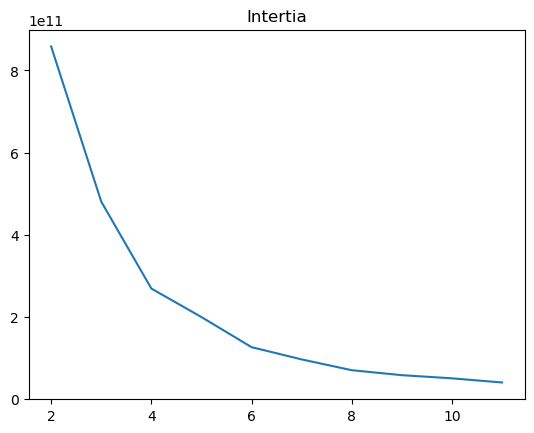

In [247]:
plt.plot(x,wcss)
plt.title('Intertia')

### Looks like we should go for cluster number 6
Let's do that

In [248]:
mkmeans = MiniBatchKMeans(n_clusters= 6)
mkmeans.fit(df_train)

/home/infinity/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=6)

### Getting Cluster predictions

In [249]:
# Get predictions
mkmeans.predict(df_train)

array([3, 0, 4, ..., 5, 0, 0], dtype=int32)

In [250]:
# Store predictions
df_train['Cluster_labels'] = mkmeans.predict(df_train)

In [251]:
df_train

,Sex,Marital status,Age,Education,Income,Occupation,Cluster_labels
1100,0,0,38,1,82398,1,3
13,0,0,60,2,89374,0,0
1757,1,0,35,1,116176,0,4
452,0,0,34,1,113609,1,0
102,1,1,24,1,95186,1,0
...,...,...,...,...,...,...,...
698,0,0,24,0,96425,1,0
1502,1,0,27,1,97192,1,0
808,0,0,55,1,231992,2,5
810,0,1,26,1,101511,1,0


### Saving the model

In [252]:
from joblib import load,dump

In [253]:
dump(mkmeans,'models/MiniBatchKMeans.pkl')

['models/MiniBatchKMeans.pkl']

### Loading the model

In [254]:
loaded_model = load('models/MiniBatchKMeans.pkl')

In [255]:
loaded_model

MiniBatchKMeans(n_clusters=6)

### Now, let's say we get new data 

In [256]:
df_test

,Sex,Marital status,Age,Education,Income,Occupation
1303,1,0,33,1,109489,1
533,0,1,26,1,109890,1
1634,1,0,36,1,75297,0
1326,1,1,24,1,122846,1
1122,0,0,42,1,159745,2
...,...,...,...,...,...,...
763,0,0,30,0,235660,2
1194,0,1,26,1,97932,2
1819,1,1,18,1,100924,1
662,0,0,50,1,121400,1


### We have 2 options
1. Either use the previous model to make predictions on this new dataset
2. Use the new data to train the model further and then make predictions

Let's try approach 1 first. 

In [258]:
loaded_model.predict(df_test)

array([0, 0, 3, 4, 2, 3, 1, 0, 0, 0, 0, 4, 3, 4, 4, 2, 4, 0, 3, 2, 3, 0,
       0, 0, 3, 0, 5, 0, 4, 4, 3, 4, 3, 4, 0, 0, 2, 4, 3, 4, 4, 0, 3, 0,
       3, 0, 4, 2, 0, 5, 0, 0, 3, 2, 3, 0, 0, 4, 3, 2, 3, 4, 2, 4, 4, 2,
       0, 2, 2, 5, 4, 0, 3, 3, 0, 2, 2, 4, 2, 0, 2, 4, 3, 2, 2, 3, 2, 5,
       3, 4, 2, 0, 4, 4, 3, 4, 0, 4, 3, 3, 3, 0, 4, 4, 2, 4, 4, 4, 0, 5,
       2, 2, 0, 1, 5, 3, 0, 0, 3, 0, 0, 0, 4, 4, 2, 4, 4, 4, 0, 0, 5, 0,
       0, 0, 3, 0, 3, 0, 0, 3, 0, 4, 0, 0, 3, 3, 0, 4, 3, 0, 2, 3, 3, 4,
       4, 0, 5, 2, 0, 0, 4, 4, 3, 4, 4, 4, 0, 5, 3, 4, 2, 4, 2, 0, 2, 0,
       0, 0, 0, 4, 4, 5, 2, 0, 4, 0, 3, 4, 0, 2, 3, 0, 2, 1, 0, 3, 0, 0,
       0, 0, 4, 2, 4, 4, 5, 0, 2, 4, 3, 5, 4, 4, 0, 0, 2, 0, 3, 3, 4, 3,
       0, 0, 1, 4, 0, 0, 0, 0, 4, 3, 0, 4, 0, 4, 0, 0, 2, 3, 0, 4, 2, 5,
       4, 0, 2, 0, 0, 0, 2, 5, 0, 4, 4, 5, 0, 5, 4, 4, 4, 3, 4, 0, 0, 5,
       2, 0, 2, 4, 0, 0, 0, 2, 4, 0, 3, 5, 0, 4, 0, 3, 4, 3, 4, 0, 2, 3,
       0, 3, 4, 4, 0, 1, 4, 0, 4, 0, 4, 5, 0, 3, 4,

In [259]:
df_test['Old_model_clusters'] = loaded_model.predict(df_test)

In [260]:
df_test

,Sex,Marital status,Age,Education,Income,Occupation,Old_model_clusters
1303,1,0,33,1,109489,1,0
533,0,1,26,1,109890,1,0
1634,1,0,36,1,75297,0,3
1326,1,1,24,1,122846,1,4
1122,0,0,42,1,159745,2,2
...,...,...,...,...,...,...,...
763,0,0,30,0,235660,2,1
1194,0,1,26,1,97932,2,0
1819,1,1,18,1,100924,1,0
662,0,0,50,1,121400,1,4


Approach 2 

### Let's try to retrain the model


In [261]:
df_test_temp = df_test.drop('Old_model_clusters',axis=1)

In [262]:
# I am going to retrain the model
loaded_model = loaded_model.partial_fit(df_test_temp)

In [263]:
loaded_model

MiniBatchKMeans(n_clusters=6)

In [264]:
loaded_model.predict(df_test_temp)

array([0, 0, 3, 4, 2, 3, 1, 0, 0, 0, 0, 4, 3, 4, 4, 2, 4, 0, 3, 2, 3, 0,
       0, 0, 3, 0, 5, 0, 4, 4, 3, 4, 3, 4, 0, 0, 2, 4, 3, 4, 4, 0, 3, 0,
       3, 0, 4, 2, 0, 5, 0, 0, 3, 2, 3, 0, 0, 4, 3, 2, 3, 4, 2, 4, 4, 2,
       0, 2, 2, 5, 4, 0, 3, 3, 0, 2, 2, 4, 2, 0, 2, 4, 3, 2, 2, 3, 2, 5,
       3, 4, 2, 0, 4, 4, 3, 4, 0, 4, 3, 3, 3, 0, 4, 4, 2, 4, 4, 4, 0, 5,
       2, 2, 0, 1, 5, 3, 0, 0, 3, 0, 0, 0, 4, 4, 2, 4, 4, 4, 0, 0, 5, 0,
       0, 0, 3, 0, 3, 0, 0, 3, 0, 4, 0, 0, 3, 3, 0, 4, 3, 0, 2, 3, 3, 4,
       4, 0, 5, 2, 0, 0, 4, 4, 3, 4, 4, 4, 0, 5, 3, 4, 2, 4, 2, 0, 2, 0,
       0, 0, 0, 4, 4, 5, 2, 0, 4, 0, 3, 4, 0, 2, 3, 0, 2, 1, 0, 3, 0, 0,
       0, 0, 4, 2, 4, 4, 5, 0, 2, 4, 3, 5, 4, 4, 0, 0, 2, 0, 3, 3, 4, 3,
       0, 0, 1, 4, 0, 0, 0, 0, 4, 3, 0, 4, 0, 4, 0, 0, 2, 3, 0, 4, 2, 5,
       4, 0, 2, 0, 0, 0, 2, 5, 0, 4, 4, 5, 0, 5, 4, 4, 4, 3, 4, 0, 0, 5,
       2, 0, 2, 4, 0, 0, 0, 2, 4, 0, 3, 5, 0, 4, 0, 3, 4, 3, 4, 0, 2, 3,
       0, 3, 4, 4, 0, 1, 4, 0, 4, 0, 4, 5, 0, 3, 4,

In [265]:
df_test['New_model_labels'] = loaded_model.predict(df_test_temp)

In [266]:
df_test

,Sex,Marital status,Age,Education,Income,Occupation,Old_model_clusters,New_model_labels
1303,1,0,33,1,109489,1,0,0
533,0,1,26,1,109890,1,0,0
1634,1,0,36,1,75297,0,3,3
1326,1,1,24,1,122846,1,4,4
1122,0,0,42,1,159745,2,2,2
...,...,...,...,...,...,...,...,...
763,0,0,30,0,235660,2,1,1
1194,0,1,26,1,97932,2,0,0
1819,1,1,18,1,100924,1,0,0
662,0,0,50,1,121400,1,4,4


### Plotting

In [267]:
df_test[['Old_model_clusters','New_model_labels']].corr()

,Old_model_clusters,New_model_labels
Old_model_clusters,1.0,1.0
New_model_labels,1.0,1.0


### We see that there were indeed some updates

### Decomposition / feature Extraction
- ```sklearn.decomposition.MiniBatchDictionaryLearning```
- ```sklearn.cluster.MiniBatchKMeans```